# Billboard project
AKA: "Image To Text To Translate To Speech"

The flow of the program is pretty straight-froward. We use 4 different high-level AI APIs provided by AWS to read text from an image. Access to those APIs is provided by the *Boto3* python library.

In [2]:
# Libs
import os
import boto3
import pygame
import json
import urllib, time
from twython import TwythonStreamer


# Global vars
defaultRegion = 'eu-west-1'
bucket = 'billboard-demo'
folder = ''
image_name = 'quote.jpg'
# Twitter connection params
cons_key = os.environ['TWITT_CONS_KEY']
cons_secret = os.environ['TWITT_CONS_SECRET']
access_key = os.environ['TWITT_ACCESS_KEY']
access_secret = os.environ['TWITT_ACCESS_SECRET']
twitter_username = os.environ['TWITT_USERNAME']

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# A handy dictionary with language-voice pair
lan_voice = {
    'en': 'Brian',
    'fr': 'Mathieu',
    'it': 'Carla',
    'es': 'Enrique',
    'de': 'Hans'
}

First the text is extracted by means of the *Rekognition Api*.

In [4]:
# Rekognition API
class re:
    def connect(regionName=defaultRegion):
        return boto3.client('rekognition', region_name=regionName)

    def detectText(client, bucket, image):
        response = client.detect_text(Image={'S3Object': {'Bucket':bucket, 'Name':image}})
        text = '' 
        for t in response['TextDetections']:
            if t['Type'] == 'LINE':
                text = text+t['DetectedText']+' '
        return text

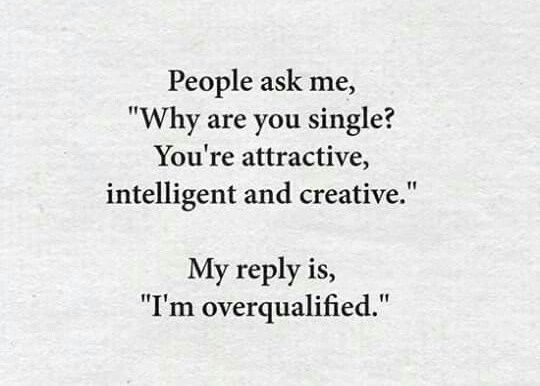

In [5]:
from IPython.display import Image
Image(boto3.resource('s3').Object(bucket, folder+image_name).get()['Body'].read())

In [6]:
# Connect to the rekognition client
rekognition = re.connect()
# Detect the text
text = re.detectText(rekognition, bucket, folder+image_name)
print("Detected text: " + text)

Detected text: People ask me, "Why are you single? You're attractive, intelligent and creative." My reply is, "I'm overqualified." 


Then, the extracted text is processed via the *Comprehend API* to understand the language.

In [7]:
# Comprehend API
class co:
    def connect(regionName=defaultRegion):
        return boto3.client('comprehend', region_name=regionName)

    def detectLanguage(client,text):
        resp = client.detect_dominant_language(Text=text)
        return resp['Languages'][0]['LanguageCode']

In [8]:
# Connect to the Comprehend client
comprehend = co.connect()
# Detect the language
language = co.detectLanguage(comprehend, text)
print("Detected language: " + language)

Detected language: en


Then, we translate this text through the *Translate API* and let the translated text be played by *Polly*.

In [9]:
# Translate API
class tr:
    def connect(regionName=defaultRegion):
        return boto3.client('translate', region_name=regionName)

    def translateText(client, text, source, target):
        response = client.translate_text(Text=text, SourceLanguageCode=source, TargetLanguageCode=target)
        return response['TranslatedText']

In [10]:
# Polly API
defaultUrl = 'https://polly.eu-west-1.amazonaws.com'

class po:
    def connect(regionName=defaultRegion, endpointUrl=defaultUrl):
        return boto3.client('polly', region_name=regionName, endpoint_url=endpointUrl)

    def play(filename):
        pygame.init()
        pygame.mixer.music.load(filename)
        pygame.mixer.music.play()
        while pygame.mixer.music.get_busy():
            pygame.time.Clock().tick(10)

    def speak(polly, text, format='ogg_vorbis', voice='Brian'):
        filename = po.file_gen(polly, text, format, voice)
        po.play(filename)
        os.remove(filename)
        
    def file_gen(polly, text, format='ogg_vorbis', voice='Brian'):
        filename="/tmp/sound.ogg"
        resp = polly.synthesize_speech(OutputFormat=format, Text=text, VoiceId=voice)
        soundfile = open(filename, 'wb')
        soundBytes = resp['AudioStream'].read()
        soundfile.write(soundBytes)
        soundfile.close()
        return filename

In [11]:
# Connect to the Translate and the Polly client
translate = tr.connect()
polly = po.connect()

# Read the text in different languages
print("English: " + text)
po.speak(polly, text, voice='Brian')

# Translate and read!
for key in lan_voice.keys():
    if key == 'en':
        continue
    translated_text = tr.translateText(translate, text, language, key)
    print(key.upper()+": " + translated_text)
    po.speak(polly, translated_text, voice=lan_voice.get(key))

English: People ask me, "Why are you single? You're attractive, intelligent and creative." My reply is, "I'm overqualified." 
FR: Les gens me demandent : « Pourquoi es-tu célibataire ? Vous êtes séduisante, intelligente et créative. » Ma réponse est : « Je suis surqualifiée. »


KeyboardInterrupt: 

### Let's have fun!

Let's build a Twitter bot, which accepts an image by means of a mention, then replies with a mention with the text recognized in the image and an audio file playing the text.

![image](./billboard_schema.png)

In [12]:
from twython import Twython

status_saved = ''
debug = False

class MyStreamListener(TwythonStreamer):
    
    cons_key = os.environ['TWITT_CONS_KEY']
    cons_secret = os.environ['TWITT_CONS_SECRET']
    access_key = os.environ['TWITT_ACCESS_KEY']
    access_secret = os.environ['TWITT_ACCESS_SECRET']
    
    
    default_policy = {
        "Version": "2008-10-17",
        "Id": "PolicyForPublicWebsiteContent",
        "Statement": [
            {
                "Sid": "PublicReadGetObject",
                "Effect": "Allow",
                "Principal": {
                    "AWS": "*"
                },
                "Action": "s3:GetObject",
                "Resource": [
                    "arn:aws:s3:::{}/{}quote.jpg".format(bucket, folder),
                    "arn:aws:s3:::{}/{}billboard.jpg".format(bucket, folder)
                ]
            }
        ]
    }
    
    def on_success(self, status):
        if not self.process(status):
            self.disconnect()
    
    def process(self, status):
        global status_saved
        if debug:
            status_saved = status
        # New update logic is here!
        if '@{}'.format(twitter_username) in status['text']:
            # The bot has been mentioned - react to it
            try:
                user = status['user']['screen_name']
                text = status['text']
                image_url = status['extended_entities']['media'][0]['media_url_https']
            except Exception as e:
                print('There were some problems with extracting info from the status - {}.'.format(e))
                return (False if debug else True)
            ######################
            # IMAGE HANDLING
            ######################
            # Download the image
            try:
                timestamp = time.time()
                file_ext = image_url.split('.')[-1:][0]
                image_name = '{}-{}.{}'.format(user, timestamp, file_ext)
                image_loc = '/tmp/{}'.format(image_name)
                urllib.request.urlretrieve(image_url, image_loc)
            except Exception as e:
                print('There were some problems with downloading the image from the post - {}.'.format(e))
                return (False if debug else True)
            # Upload the iamge to S3
            try:
                s3 = boto3.client('s3')
                # Create a folder for the user
                folder_s3 = '{}{}-{}/'.format(folder,user,timestamp)
                s3.put_object(Bucket=bucket, Body='', Key=folder_s3)
                s3.put_object(Bucket=bucket, Body=open(image_loc,'rb'), Key=folder_s3+image_name)
            except Exception as e:
                print('There were some problems with uploading the image to S3 - {}.'.format(e))
                return (False if debug else True)
            ######################
            # POLICIES HANDLING
            ######################
            # Test if the bucket is set for static web hosting
            try:
                boto3.client('s3').get_bucket_website(Bucket=bucket)
            except Exception:
                boto3.client('s3').put_bucket_website(
                    Bucket=bucket,
                    WebsiteConfiguration={
                        'ErrorDocument': {'Key': 'error.html'},
                        'IndexDocument': {'Suffix': 'index.html'},
                    }
                )
            # Set the access in the bucket policies
            try:
                boto3.client('s3').get_bucket_policy(Bucket=bucket)
            except Exception as e:
                if 'NoSuchBucketPolicy' in str(e):
                    bucket_policy = json.dumps(self.default_policy)
                    boto3.client('s3').put_bucket_policy(Bucket=bucket, Policy=bucket_policy)
                else:
                    print('There were some problems with the bucket policy - {}.'.format(e))
                    return (False if debug else True)   
            try:
                bucket_policy = boto3.resource('s3').BucketPolicy(bucket)
                bucket_policy.reload()
                policy = json.loads(bucket_policy.policy)
                policy['Statement'][0]['Resource'] += ['arn:aws:s3:::{}/{}*'.format(bucket,folder_s3)]
                bucket_policy.put(Policy=json.dumps(policy))
                bucket_policy.reload()
            except Exception as e:
                print('There were some problems with updating the bucket policy - {}.'.format(e))
                return (False if debug else True)
            ######################
            # REKOGNITION API
            ######################
            # Recognise the text via the Rekognition API
            try:
                rekognition = re.connect()
                text = re.detectText(rekognition, bucket, folder_s3+image_name)
            except Exception as e:
                print('Rekognition API had some problems - {}.'.format(e))
                return (False if debug else True)
            ######################
            # COMPREHEND API
            ######################
            # Detect the language via the Comprehend API
            try:
                comprehend = co.connect()
                language = co.detectLanguage(comprehend, text)
            except Exception as e:
                print('Comprehend API had some problems - {}.'.format(e))
                return (False if debug else True)
            ######################
            # POLLY API
            ######################
            # Generate the voice to be played
            try:
                polly = po.connect()
                soundfile = po.file_gen(polly, text, voice=lan_voice[language])
            except Exception as e:
                print('Polly API had some problems - {}.'.format(e))
                return (False if debug else True)
            ######################
            # SOUND AND HTML UPLOAD
            ######################
            # Prepare the folder with the content to serve
            try:
                folder_url = 'http://{}.s3-website-{}.amazonaws.com/{}'.format(bucket, defaultRegion, folder_s3)
                # upload the audio file to S3
                s3.put_object(Bucket=bucket, Body=open(soundfile,'rb'), Key=folder_s3+'audio.ogg', ContentType='audio/ogg')
                # upload the HTML and robots files to generate the player card
                with open('html/index.html', 'r') as file :
                    filedata = file.read()
                    filedata = filedata.replace('$$$$', folder_url+'container.html')
                s3.put_object(Bucket=bucket, Body=filedata.encode(), Key=folder_s3+'index.html', ContentType='text/html')
                s3.put_object(Bucket=bucket, Body=open('html/container.html','rb'), Key=folder_s3+'container.html', ContentType='text/html')
                s3.put_object(Bucket=bucket, Body=open('html/robots.txt','rb'), Key=folder_s3+'robots.txt', ContentType='text/plain')
            except Exception as e:
                print('Uploading to S3 has caused some problems - {}.'.format(e))
                return (False if debug else True)
            ######################
            # RESPOND TO THE TWEET
            ######################
            # Post about the detected text
            try:
                # TODO: should work by just specifying index.html instead of audio.ogg - but for some reason it does not.
                audio_url = 'http://{}.s3-website-{}.amazonaws.com/{}audio.ogg'.format(bucket, defaultRegion, folder_s3)
                tweet = 'Hi @{} . I detected text in {}, saying: "{}" - {}'.format(user, language.upper(), text, audio_url)
                # Create a new Trython instance to post update
                twitter = Twython(cons_key, cons_secret, access_key, access_secret)
                twitter.update_status(status=tweet)
            except Exception as e:
                print('There were some issues in posting the response - {}.'.format(e))
                return (False if debug else True)
            print('Completed posting for {}'.format(folder_s3))
            return (False if debug else True) # Return false to disconnect the stream
        
    def on_error(self, status_code, data):
        ######################
        # ERROR STATUS CODE HANDLING
        ######################
        if status_code == 410:
            print('[{}] The requested resource was not found - API is offline.'.format(status_code))
            self.disconnect()
        elif status_code == 420:
            print('[{}] Exceeded connection limit for user.'.format(status_code))
            self.disconnect()
        elif status_code == 500:
            print('[{}] Internal Server Error.'.format(status_code))
            self.disconnect()
        elif status_code == 502:
            print('[{}] Twitter is offline.'.format(status_code))
            self.disconnect()
        else:
            print('[{}] Unknown error code - dropping connection.'.format(status_code))
            self.disconnect()

In [ ]:
try:
    # Connect the stream
    stream = MyStreamListener(cons_key, cons_secret, access_key, access_secret)
    print('Stream Listener is now ready to serve! Listening user: {}'.format(twitter_username))
    # Start listening for incoming mentions
    stream.statuses.filter(track=[twitter_username])
except KeyboardInterrupt:
    print('SIGTERM received. Killing Stream Listener ...')
    stream.disconnect()

Stream Listener is now ready to serve! Listening user: AWS_FR_Demo
Completed posting for DGallitelli95-1536311932.0666618/
